In [1]:
using DataFrames, FileIO, DelimitedFiles
using Plots, Optim, LsqFit, JUMD
using Statistics, NamedArrays

In [2]:
# Get ready
dir_apo_hbo = "/home/pbarletta/labo/20/cph_obp/run/apo/hbond"

nstlim = 19500
phs = collect(30:5:75)
idx = collect(1:10)
pdt_steps = collect(0:1:7)
titrable_cnt = 36
titrable_resis = [4, 5, 7, 11, 13, 18, 20, 24, 27, 30, 33, 37, 39,
    40, 41, 42, 48, 52, 58, 59, 64, 69, 73, 77, 78, 82, 87, 93, 94,
    97, 99, 102, 109, 111, 114, 117];
titrable_resnames = ["GL4", "GL4", "LYS", "HIP", "GL4", "LYS", "GL4", "AS4", "LYS",
    "AS4", "GL4", "AS4", "GL4", "AS4", "LYS", "LYS", "GL4", "LYS",
    "AS4", "LYS", "LYS", "LYS", "GL4", "AS4", "GL4", "LYS", "AS4",
    "GL4", "GL4", "HIP", "LYS", "LYS", "LYS", "LYS", "LYS", "AS4"];

In [7]:
for i in 1:10
    global nhb_apo_idx = convert(Array{Float64, 1}, readdlm(joinpath(dir_apo_hbo, string(idx[i]),
            string("nhb_apo_", idx[i])))[2:end, 2])
    global nhb_apo_phs = convert(Array{Float64, 1}, readdlm(joinpath(dir_apo_hbo, string(phs[i], "ph"),
            string("nhb_apo_", phs[i])))[2:end, 2])

    sym_nhb_apo_idx = Symbol("nhb_apo_", idx[i])
    sym_nhb_apo_phs = Symbol("nhb_apo_", phs[i])
    eval(:($sym_nhb_apo_idx = nhb_apo_idx))
    eval(:($sym_nhb_apo_phs = nhb_apo_phs))
end

## hbonds count por pH

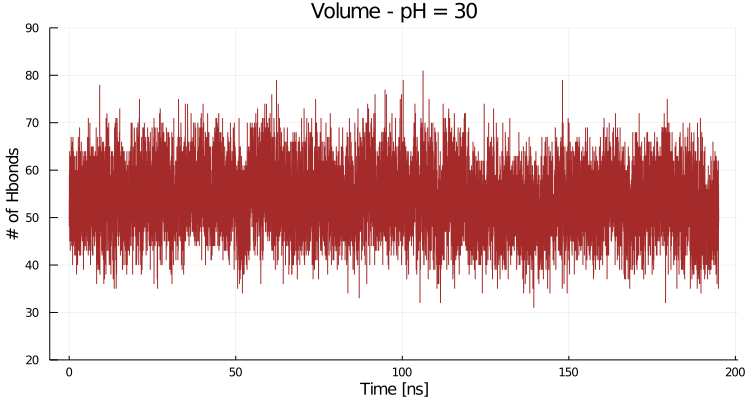

In [23]:
min_nhb = 20
max_nhb = 90
plot(collect(1:nstlim) ./ 100, nhb_apo_30,
    title = string("nhbume - pH = ", 30), size = (750, 400),
    ylims = (min_nhb, max_nhb), label = false,
    linecolor = Colors.colorant"Brown",
    yaxis = "# of Hbonds", xaxis = "Time [ns]")

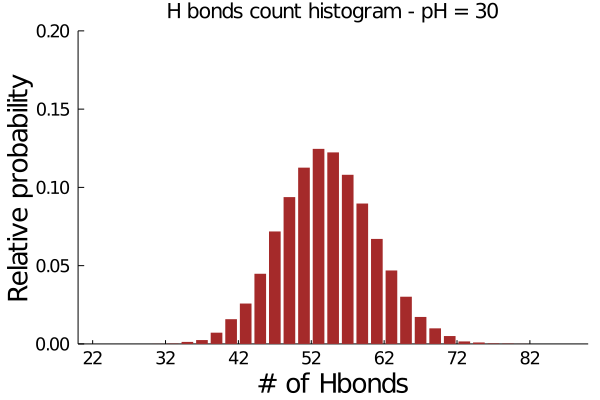

In [25]:
st = 2
bin_nhb = collect(min_nhb:st:max_nhb)
wgh_nhb = fill(1.0, length(nhb_apo_30))

# Histograma ponderado
Wbins_nhb, Whis_nhb = JUMD.weightedHist(nhb_apo_30, bin_nhb, wgh_nhb, true, false);

bar(Wbins_nhb, Whis_nhb,
    xlims = (min_nhb, max_nhb), ylims = (0, .2),
    xticks = min_nhb+st:10:max_nhb+st,
    linecolor = false, fillcolor = Colors.colorant"Brown",
    grid = false, legend = false,
    guidefont = font(18, "Arial"), tickfont = font(12, "Arial"),
    legendfont = font(12, "Arial"),
    title = string("H bonds count histogram - pH = ", 30),
    yaxis = "Relative probability", xaxis = "# of Hbonds")

In [16]:
vals = vcat([ mean(nhb_apo_30) std(nhb_apo_30) std(nhb_apo_30) / mean(nhb_apo_30) ],
    [ mean(nhb_apo_35) std(nhb_apo_35) std(nhb_apo_35) / mean(nhb_apo_35) ],
    [ mean(nhb_apo_40) std(nhb_apo_40) std(nhb_apo_40) / mean(nhb_apo_40) ])
    
NamedArray(vals, (string.(phs[1:3]), ["μ" ; "std" ; "μ/std"]))

3×3 Named Array{Float64,2}
A ╲ B │        μ       std     μ/std
──────┼─────────────────────────────
30    │  53.6252   6.40518  0.119443
35    │  55.5763   6.44623  0.115989
40    │  56.9156   6.48374  0.113918

## ## hbonds count por idx

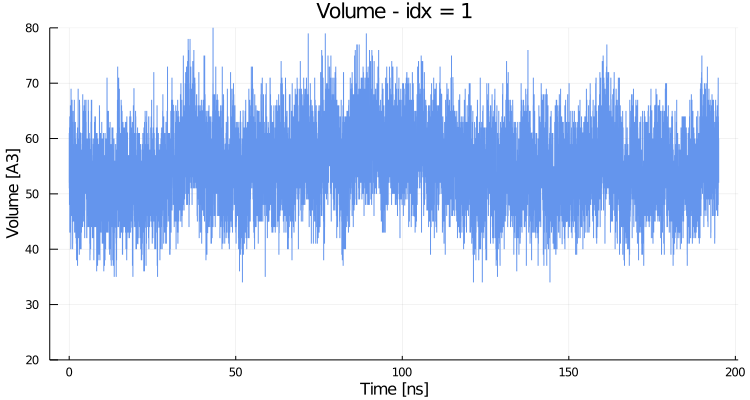

In [22]:
plot(collect(1:nstlim) ./ 100, nhb_apo_1,
    title = string("nhbume - idx = ", 1), size = (750, 400),
    ylims = (min_nhb, max_nhb), label = false,
    linecolor = Colors.colorant"CornflowerBlue",
    yaxis = "nhbume [A3]", xaxis = "Time [ns]")

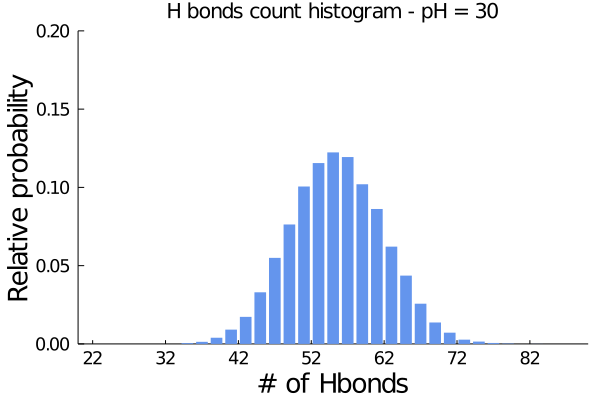

In [26]:
st = 2
bin_nhb = collect(min_nhb:st:max_nhb)
wgh_nhb = fill(1.0, length(nhb_apo_1))

# Histograma ponderado
Wbins_nhb, Whis_nhb = JUMD.weightedHist(nhb_apo_1, bin_nhb, wgh_nhb, true, false);

bar(Wbins_nhb, Whis_nhb,
    xlims = (min_nhb, max_nhb), ylims = (0, .2),
    xticks = min_nhb+st:10:max_nhb+st,
    linecolor = false, fillcolor = Colors.colorant"CornflowerBlue",
    grid = false, legend = false,
    guidefont = font(18, "Arial"), tickfont = font(12, "Arial"),
    legendfont = font(12, "Arial"),
    title = string("H bonds count histogram - pH = ", 30),
    yaxis = "Relative probability", xaxis = "# of Hbonds")

In [27]:
NamedArray([ mean(nhb_apo_1) std(nhb_apo_1) std(nhb_apo_1) / mean(nhb_apo_1) ],
    (["# of Hbonds"], ["μ" ; "std" ; "μ/std"]))

1×3 Named Array{Float64,2}
      A ╲ B │        μ       std     μ/std
────────────┼─────────────────────────────
# of Hbonds │  55.0166   6.39254  0.116193

In [60]:
temporal = readdlm(joinpath(dir_apo_hbo, string(phs[1], "ph"),
        string("series_nhb_apo_gl4_as4_acc_", phs[1])), header = true)

res_hbo_apo_idx = convert(Array{Bool, 2}, temporal[1][:, 2:end])
donor_acceptor = convert(Array{String, 1}, temporal[2][2:end]);

In [67]:
findall(res_hbo_apo_idx[3, :])

1-element Array{Int64,1}:
 3

In [ ]:
convert(Array{Bool, 2}
    [:, 2:end]

In [68]:
res_hbo_apo_idx

19500×151 Array{Bool,2}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  1  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0 

In [69]:
temporal[1][:, 2:end]

19500×151 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  